In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import StackingRegressor

# Importing the Dataset

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.head())
print("-"*50)
print(train.info())
print("-"*50)
print(train.describe())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

# Data Preprocessing

In [3]:
# Fill missing values for numerical features with the median
numerical_features = train.select_dtypes(include=['int64', 'float64']).columns
numerical_features = numerical_features.drop('SalePrice')
for feature in numerical_features:
    train[feature] = train[feature].fillna(train[feature].median())
    test[feature] = test[feature].fillna(test[feature].median())
# Fill missing values for categorical features with the mode of a specific category
categorical_features = train.select_dtypes(include=['object']).columns
for feature in categorical_features:
    train[feature] = train[feature].fillna('None')
    test[feature] = test[feature].fillna('None')

In [4]:
#  Encode categorical variables using one-hot encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)
# Align the train and test dataframes by the columns
train, test = train.align(test, join='left', axis=1, fill_value=0)

# Feature Engineering

In [5]:
# Adding these features creates a new feature (TotalSF)
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

# Feature Selection

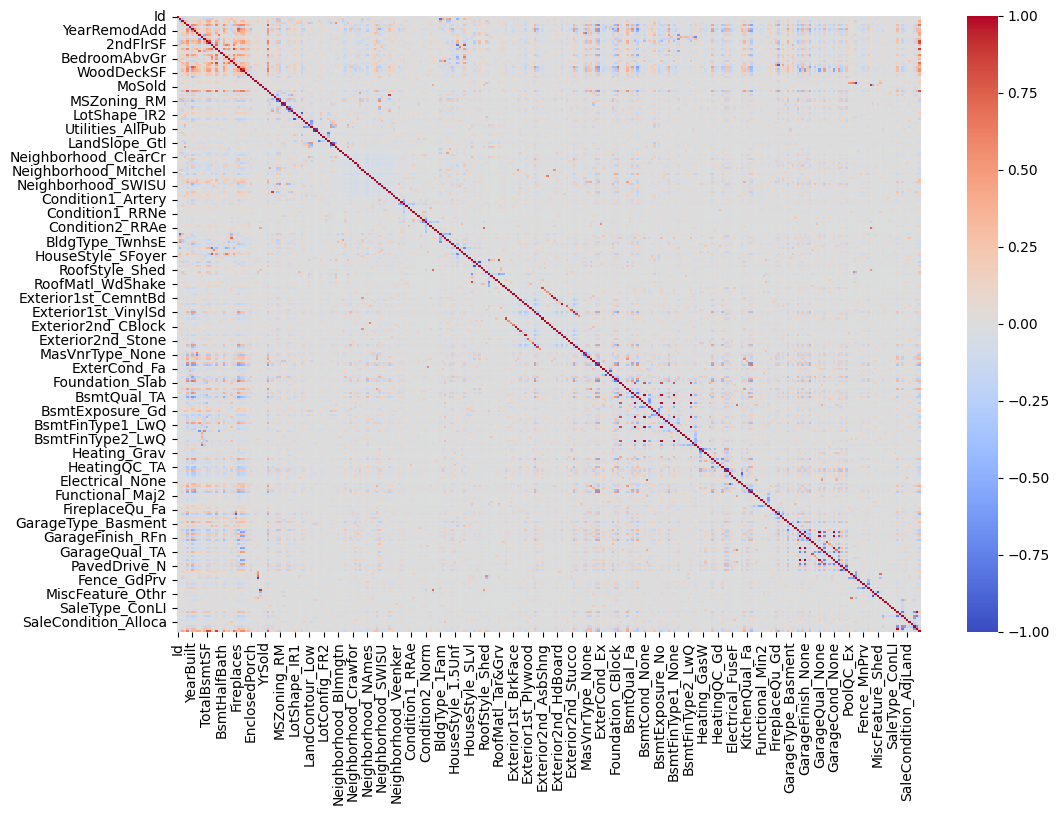

In [6]:
train = train.apply(pd.to_numeric, errors='coerce')
corr_matrix = train.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

In [7]:
# Selecting top 10 correlated features with SalePrice
top_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(11).index
print(top_features)

Index(['SalePrice', 'OverallQual', 'TotalSF', 'GrLivArea', 'GarageCars',
       'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'ExterQual_TA', 'FullBath',
       'BsmtQual_Ex'],
      dtype='object')


# Model Selection
Split the training data into training and validation sets, train multiple models and evaluate their performance using RMSLE.

In [8]:
X = train[top_features].drop('SalePrice', axis=1)
y = train['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(alpha=0.001, max_iter=10000),
}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmsle = mean_squared_log_error(y_val, preds) ** 0.5
    print(f'{name} RMSLE: {rmsle}')

Linear Regression RMSLE: 0.19180310904676282
Lasso RMSLE: 0.19180310871052747


# Model Tuning and Ensembling

In [10]:
stacked_model = StackingRegressor(
    estimators=[
        ('lr', LinearRegression()),
    ],
    final_estimator=Lasso(alpha=0.001)
)

stacked_model.fit(X_train, y_train)
stacked_preds = stacked_model.predict(X_val)
rmsle = mean_squared_log_error(y_val, stacked_preds) ** 0.5
print(f'Stacked Model RMSLE: {rmsle}')

Stacked Model RMSLE: 0.18887159832383124


# Making Predictions

In [11]:
final_preds = stacked_model.predict(test[top_features.drop('SalePrice')])
final_prediction = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': final_preds
})
final_prediction.to_csv('final_prediction.csv', index=False)
final_prediction.head()

,Id,SalePrice
0,1461,111325.779587
1,1462,153995.262273
2,1463,155257.722883
3,1464,171211.757838
4,1465,216952.220788
